still being tweaked!

to try: add lambdas between modalities, annealing betas

### Extensions to a multimodal VAE

Another way this model can be extended is to fully let the latent $z$ "cause" both the emotion ratings and the facial expression. This is an example of a Multimodal VAE (Wu & Goodman, 2018).

There is a nice theoretical motivation for this model too. Throughout the past few examples, we've assumed that the space of emotions is exactly what we measured (e.g., some value of happiness, some value of sadness), but maybe the latent space is more structured, but not along these discrete emotion categories -- perhaps along dimensions like "good" vs "bad", or . In emotion theory, this undifferentiated space is called affect, and often, this is a low-dimensional space (2 to 3 dimensions capture most of the variance in empirical data).

We could thus posit a latent *affect* that generates the emotion ratings. That is, the emotion ratings is some projection of the latent affect space onto these emotion concepts that are given meaning by the language and culture that one resides in.

But in fact, we would still want a latent $z$ that captures non-emotional aspects of the face. For simplicity, for this example, we assume that this latent $z$ will capture some aspects of affect as well as the face. Learning to disentangle latent variables (e.g. the latent variables that are important for emotions and the latent variables that are not) is also an active area of research (Narayanaswamy et al, 2017).

And finally, we can add the "outcome to appraisal to affect" part back into this multimodal model.

<div style="width: 300px; margin: auto; ">![Graphical Model](images/graphicalModel_MVAE.png)
</div>

In [1]:
#from __future__ import division, print_function, absolute_import
from __future__ import print_function

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


from torchvision import transforms, utils, datasets
from torchvision.transforms import ToPILImage
from skimage import io, transform
from scipy.special import expit
from PIL import Image
from matplotlib.pyplot import imshow

from pyro.contrib.examples.util import print_and_log, set_seed
import pyro.poutine as poutine
# custom helperCode for this tutorial, in helperCode.py
import helperCode
from utils.custom_mlp import MLP, Exp


from visdom import Visdom

#from utils.vae_plots import plot_llk, plot_vae_samples
from utils.mnist_cached import  mkdir_p, setup_data_loaders
from utils.vae_plots import plot_conditional_samples_ssvae, plot_vae_samples

#IMG_WIDTH = 100
#IMG_SIZE = IMG_WIDTH*IMG_WIDTH*3
# Note that we downsample to 64 x 64 here, because we wanted a nice power of 2 
#(and DCGAN architecture assumes input image of 64x64) 
IMG_WIDTH = 64
IMG_SIZE = IMG_WIDTH*IMG_WIDTH*3
BATCH_SIZE = 32
DEFAULT_HIDDEN_DIMS = [500, 500]#[200,200] #[500, 500]
DEFAULT_Z_DIM = 50#10#50#2

# FACE_VAR_NAMES = ['facePath']
OUTCOME_VAR_NAMES = ['payoff1', 'payoff2', 'payoff3', 
                     'prob1', 'prob2', 'prob3', 
                     'win', 'winProb', 'angleProp']
EMOTION_VAR_NAMES = ['happy', 'sad', 'anger', 'surprise', 
                     'disgust', 'fear', 'content', 'disapp']

OUTCOME_VAR_DIM = len(OUTCOME_VAR_NAMES)
EMOTION_VAR_DIM = len(EMOTION_VAR_NAMES)

class Swish(nn.Module):
    """https://arxiv.org/abs/1710.05941"""
    def forward(self, x):
        return x * F.sigmoid(x)

def swish(x):
    return x * F.sigmoid(x)

#### Dataset

(This part is the same as the SSVAE Tutorial)

We will be using the same dataset as the previous examples. We will consider the trials in which participants only saw a facial expression, and rated how they thought the character feels, or what we call the "facial expression only" trials.

Here is a preview of the 18 faces (which are in ../CognitionData/faces/).

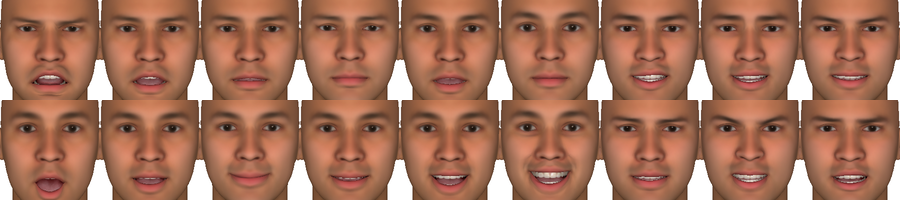

In [2]:
faces_path = os.path.join(os.path.abspath('..'), "CognitionData", "faces")

# initializing two temp arrays
faceArray1 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray2 = np.zeros(shape=(100,1,3), dtype='uint8')

count = 0
for thisFace in helperCode.FACE_FILENAMES:
    newFaceArray = np.array(Image.open(os.path.join(faces_path, thisFace + ".png")))
    if count < 6 or count > 14:
        faceArray1 = np.concatenate((faceArray1, newFaceArray), axis=1)
    else:
        faceArray2 = np.concatenate((faceArray2, newFaceArray), axis=1)
    count += 1

# concatenating the arrays and removing the first temp column
faceArray = np.concatenate((faceArray1, faceArray2), axis=0)
faceArray = faceArray[:,1:,:]
Image.fromarray(faceArray)

This next chunk defines a function to read in the data, and stores the data in `face_outcome_emotion_dataset`. There are N=1,587 observations, and each observation consists of:

- an accompanying face image
- a 9-dimension outcome vector that parameterizes the gamble that agents played, and
- an 8-dimensional emotion rating vector

Reading in dataset...
Number of observations: 1587
Sample Observation: 
['happy', 'sad', 'anger', 'surprise', 'disgust', 'fear', 'content', 'disapp']
[0.875 0.125 0.125 0.625 0.125 0.125 0.5   0.125]
['payoff1', 'payoff2', 'payoff3', 'prob1', 'prob2', 'prob3', 'win', 'winProb', 'angleProp']
[0.15  0.7   0.8   0.45  0.29  0.26  0.8   0.26  0.457]


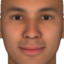

In [3]:
# data location
dataset_path = os.path.join(os.path.abspath('..'), "CognitionData", "data_faceWheel.csv")

class FaceOutcomeEmotionDataset(Dataset):
    """Face Outcome Emotion dataset."""
    
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the experiment csv file 
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.expdata = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        ## Normalizing the data:
        ####
        ## payoff1, payoff2, payoff3 and win are between 0 and 100
        ## need to normalize to [0,1] to match the rest of the variables,
        ## by dividing payoff1, payoff2, payoff3 and win by 100
        ####
        self.expdata.loc[:,"payoff1"] = self.expdata.loc[:,"payoff1"]/100
        self.expdata.loc[:,"payoff2"] = self.expdata.loc[:,"payoff2"]/100
        self.expdata.loc[:,"payoff3"] = self.expdata.loc[:,"payoff3"]/100
        self.expdata.loc[:,"win"]     = self.expdata.loc[:,"win"]/100
        # Emotions were rated on a 1-9 Likert scale.
        # use emo <- (emo-1)/8 to transform to within [0,1]
        self.expdata.loc[:,"happy":"disapp"] = (self.expdata.loc[:,"happy":"disapp"]-1)/8

    def __len__(self):
        return len(self.expdata)

    def __getitem__(self, idx):
        ratings = np.array(self.expdata.iloc[idx]["happy":"disapp"], np.float32)
        
        outcomes = np.array(self.expdata.iloc[idx]["payoff1":"angleProp"], np.float32)
        #outcomes = np.array(self.expdata.iloc[idx]["payoff1":"winProb"], np.float32)

        img_name = os.path.join(self.img_dir, self.expdata.iloc[idx]["facePath"] + ".png")
        try:
            image = Image.open(img_name).convert('RGB')
            #image = np.array(image).astype(np.float32)

            if self.transform:
                image = self.transform(image)
        except:
            print(img_name)
            raise

        return image, ratings, outcomes

data_transform = transforms.Compose([
    # Note that we downsample to 64 x 64 here, because we wanted a nice power of 2 
    #(and DCGAN architecture assumes input image of 64x64) 
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
    ])

# reads in datafile.
print("Reading in dataset...")

face_outcome_emotion_dataset = FaceOutcomeEmotionDataset(csv_file=dataset_path, 
                                                         img_dir=faces_path, 
                                                         transform=data_transform)
face_outcome_emotion_loader = torch.utils.data.DataLoader(face_outcome_emotion_dataset,
                                                          batch_size=BATCH_SIZE, shuffle=True,
                                                          num_workers=4)

N_samples = len(face_outcome_emotion_dataset)
print("Number of observations:", N_samples)

# taking a sample observation
img1, emo1, out1 = face_outcome_emotion_dataset[5]
print("Sample Observation: ")
print(helperCode.EMOTION_VAR_NAMES)
print(emo1)
print(helperCode.OUTCOME_VAR_NAMES)
print(out1)
Image.fromarray(helperCode.TensorToPILImage(img1*255.))

https://arxiv.org/abs/1802.05335

In [4]:
class ProductOfExperts(nn.Module):
    """
    Return parameters for product of independent experts.
    See https://arxiv.org/pdf/1410.7827.pdf for equations.

    @param loc: M x D for M experts
    @param scale: M x D for M experts
    """
    def forward(self, loc, scale, eps=1e-8):
        scale = scale + eps # numerical constant for stability
        # precision of i-th Gaussian expert (T = 1/sigma^2)
        T = 1. / scale
        product_loc = torch.sum(loc * T, dim=0) / torch.sum(T, dim=0)
        product_scale = 1. / torch.sum(T, dim=0)
        return product_loc, product_scale

In [5]:
class ImageEncoder(nn.Module):
    """
    define the PyTorch module that parametrizes q(z|image).
    This goes from images to the latent z
    
    This is the standard DCGAN architecture.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(ImageEncoder, self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
        #                padding=0, dilation=1, groups=1, bias=True)
        # H_out = floor( (H_in + 2*padding - dilation(kernel_size-1) -1) / stride    +1)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            Swish(),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            Swish(),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            Swish(),
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            Swish())
        # Here, we define two layers, one to give z_loc and one to give z_scale
        self.z_loc_layer = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512), # it's 256 * 5 * 5 if input is 64x64.
            #nn.Linear(256 * 9 * 9, 512), # it's 256 * 9 * 9 if input is 100x100.
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, z_dim))
        self.z_scale_layer = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512), # it's 256 * 5 * 5 if input is 64x64.
            #nn.Linear(256 * 9 * 9, 512), # it's 256 * 9 * 9 if input is 100x100.
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, z_dim))
        self.z_dim = z_dim

    def forward(self, image):
        hidden = self.features(image)
        hidden = hidden.view(-1, 256 * 5 * 5) # it's 256 * 5 * 5 if input is 64x64.
        #image = image.view(-1, 256 * 9 * 9) # it's 256 * 9 * 9 if input is 100x100.
        z_loc = self.z_loc_layer(hidden)
        z_scale = torch.exp(self.z_scale_layer(hidden)) #add exp so it's always positive
        return z_loc, z_scale
    
class ImageDecoder(nn.Module):
    """
    define the PyTorch module that parametrizes p(image|z).
    This goes from the latent z to the images
    
    This is the standard DCGAN architecture.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(ImageDecoder, self).__init__()
        self.upsample = nn.Sequential(
            nn.Linear(z_dim, 256 * 5 * 5),  # it's 256 * 5 * 5 if input is 64x64.
            #nn.Linear(z_dim, 256 * 9 * 9),  # it's 256 * 9 * 9 if input is 100x100.
            Swish())
        self.hallucinate = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            Swish(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            Swish(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            Swish(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False))

    def forward(self, z):
        # the input will be a vector of size |z_dim|
        z = self.upsample(z)
        z = z.view(-1, 256, 5, 5) # it's 256 * 5 * 5 if input is 64x64.
        #z = z.view(-1, 256, 9, 9) # it's 256 * 9 * 9 if input is 100x100.
        # but if 100x100, the output image size is 96x96
        image = self.hallucinate(z) # this is the image
        return image  # NOTE: no sigmoid here. See train.py

In [6]:
class RatingEncoder(nn.Module):
    """
    define the PyTorch module that parametrizes q(z|rating).
    This goes from ratings to the latent z

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(RatingEncoder, self).__init__()
        self.net = nn.Linear(helperCode.EMOTION_VAR_DIM, 512)
        self.z_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        self.z_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        self.z_dim = z_dim

    def forward(self, rating):
        hidden = self.net(rating)
        z_loc = self.z_loc_layer(hidden)
        z_scale = torch.exp(self.z_scale_layer(hidden))
        return z_loc, z_scale


class RatingDecoder(nn.Module):
    """
    define the PyTorch module that parametrizes p(rating|z).
    This goes from the latent z to the ratings

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(RatingDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),
            Swish())
        self.rating_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, helperCode.EMOTION_VAR_DIM))
        self.rating_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, helperCode.EMOTION_VAR_DIM))

    def forward(self, z):
        #batch_size = z.size(0)
        hidden = self.net(z)
        rating_loc = self.rating_loc_layer(hidden)
        rating_scale = torch.exp(self.rating_scale_layer(hidden))
        # rating is going to be a |emotions| * 9 levels
        #rating = h.view(batch_size, EMOTION_VAR_DIM, 9)
        return rating_loc, rating_scale  # NOTE: no softmax here. See train.py


In [7]:
class OutcomeEncoder(nn.Module):
    """
    define the PyTorch module that parametrizes q(z|outcome).
    This goes from outcomes to the latent z

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(OutcomeEncoder, self).__init__()
        self.net = nn.Linear(helperCode.OUTCOME_VAR_DIM, 512)
        self.z_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        self.z_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        self.z_dim = z_dim

    def forward(self, outcomes):
        hidden = self.net(outcomes)
        z_loc = self.z_loc_layer(hidden)
        z_scale = torch.exp(self.z_scale_layer(hidden))
        return z_loc, z_scale


class OutcomeDecoder(nn.Module):
    """
    define the PyTorch module that parametrizes p(outcomes|z).
    This goes from the latent z to the outcomes

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(OutcomeDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),
            Swish())
        self.outcome_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, helperCode.OUTCOME_VAR_DIM))
        self.outcome_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, helperCode.OUTCOME_VAR_DIM))


    def forward(self, z):
        hidden = self.net(z)
        outcome_loc = self.outcome_loc_layer(hidden)
        outcome_scale = torch.exp(self.outcome_scale_layer(hidden))
        return outcome_loc, outcome_scale  # no nonlinearity here | will be added later

In [12]:
class MVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks), models & guides needed to train a
    multimodal variational auto-encoder.
    Modified from https://github.com/mhw32/multimodal-vae-public
    Multimodal Variational Autoencoder.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
                  
    Currently all the neural network dimensions are hard-coded; 
    in a future version will make them be inputs into the constructor
    """
    def __init__(self, z_dim, use_cuda=False):
        super(MVAE, self).__init__()
        self.z_dim = z_dim
        self.image_encoder = ImageEncoder(z_dim)
        self.image_decoder = ImageDecoder(z_dim)
        self.rating_encoder = RatingEncoder(z_dim)
        self.rating_decoder = RatingDecoder(z_dim)
        self.outcome_encoder = OutcomeEncoder(z_dim)
        self.outcome_decoder = OutcomeDecoder(z_dim)
        self.experts = ProductOfExperts()
        self.use_cuda = use_cuda
        # relative weights of losses in the different modalities
        self.LAMBDA_IMAGES = 1.0
        self.LAMBDA_RATINGS = 50.0
        self.LAMBDA_OUTCOMES = 100.0
        
        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()
    
    def model(self, images=None, ratings=None, outcomes=None, annealing_beta=1.0):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("mvae", self)
        
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif ratings is not None:
            batch_size = ratings.size(0)
        elif outcomes is not None:
            batch_size = outcomes.size(0)
        
        with pyro.iarange("data", batch_size):
#             if outcomes is not None:
#                 # sample from outcome prior, compute p(z|outcome)
#                 outcome_prior_loc = torch.zeros(torch.Size((batch_size, helperCode.OUTCOME_VAR_DIM)))
#                 outcome_prior_scale = torch.ones(torch.Size((batch_size, helperCode.OUTCOME_VAR_DIM)))
#                 with poutine.scale(scale=self.LAMBDA_OUTCOMES):
#                     pyro.sample("obs_outcome", dist.Normal(outcome_prior_loc, outcome_prior_scale).independent(1),
#                                 obs=outcomes.reshape(-1, helperCode.OUTCOME_VAR_DIM))
                
#                 z_loc, z_scale = self.outcome_encoder.forward(outcomes)
#             else:
#                 # setup hyperparameters for prior p(z)
#                 z_loc = torch.zeros(torch.Size((batch_size, self.z_dim)))
#                 z_scale = torch.ones(torch.Size((batch_size, self.z_dim)))
                
                
            # sample from outcome prior N(0.5,0.1), compute p(z|outcome)
            outcome_prior_loc = torch.zeros(torch.Size((batch_size, helperCode.OUTCOME_VAR_DIM))) + 0.5
            outcome_prior_scale = torch.ones(torch.Size((batch_size, helperCode.OUTCOME_VAR_DIM))) * 0.1
            if outcomes is not None:
                # if outcome is provided as an observed input, score against it
                with poutine.scale(scale=self.LAMBDA_OUTCOMES):
                    pyro.sample("obs_outcome", dist.Normal(outcome_prior_loc, outcome_prior_scale).independent(1),
                                obs=outcomes.reshape(-1, helperCode.OUTCOME_VAR_DIM))
            else:
                # else if outcome is not provided, just sample from priors
                with poutine.scale(scale=self.LAMBDA_OUTCOMES):
                    outcomes = pyro.sample("obs_outcome", dist.Normal(outcome_prior_loc, outcome_prior_scale).independent(1))
            
            z_loc, z_scale = self.outcome_encoder.forward(outcomes)
            
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with poutine.scale(scale=annealing_beta):
                z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            
            img_loc = self.image_decoder.forward(z)
            # score against actual images
            if images is not None:
                with poutine.scale(scale=self.LAMBDA_IMAGES):
                    pyro.sample("obs_img", dist.Bernoulli(img_loc).independent(1), 
                                obs=images.reshape(-1, 3,IMG_WIDTH,IMG_WIDTH))
            
            rating_loc, rating_scale = self.rating_decoder.forward(z)
            if ratings is not None:
                with poutine.scale(scale=self.LAMBDA_RATINGS):
                    pyro.sample("obs_rating", dist.Normal(rating_loc, rating_scale).independent(1), 
                                obs=ratings.reshape(-1, helperCode.EMOTION_VAR_DIM))

            # return the loc so we can visualize it later
            return img_loc, rating_loc
    
    def guide(self, images=None, ratings=None, outcomes=None, annealing_beta=1.0):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("mvae", self)
        
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif ratings is not None:
            batch_size = ratings.size(0)
        elif outcomes is not None:
            batch_size = outcomes.size(0)
            
        with pyro.iarange("data", batch_size):
            # use the encoder to get the parameters used to define q(z|x)
                        
            # initialize the prior expert.
            # we initalize an additional dimension, along which we concatenate all the 
            #   different experts.
            # self.experts() then combines the information from these different modalities
            #   by multiplying the gaussians together
            z_loc = torch.zeros(torch.Size((1, batch_size, self.z_dim))) + 0.5
            z_scale = torch.ones(torch.Size((1, batch_size, self.z_dim))) * 0.1
            if self.use_cuda:
                z_loc, z_scale = z_loc.cuda(), z_scale.cuda()
            
            if outcomes is not None:
                outcome_z_loc, outcome_z_scale = self.outcome_encoder.forward(outcomes)
                z_loc = torch.cat((z_loc, outcome_z_loc.unsqueeze(0)), dim=0)
                z_scale = torch.cat((z_scale, outcome_z_scale.unsqueeze(0)), dim=0)
                
            if images is not None:
                image_z_loc, image_z_scale = self.image_encoder.forward(images)
                z_loc = torch.cat((z_loc, image_z_loc.unsqueeze(0)), dim=0)
                z_scale = torch.cat((z_scale, image_z_scale.unsqueeze(0)), dim=0)
            
            if ratings is not None:
                rating_z_loc, rating_z_scale = self.rating_encoder.forward(ratings)
                z_loc = torch.cat((z_loc, rating_z_loc.unsqueeze(0)), dim=0)
                z_scale = torch.cat((z_scale, rating_z_scale.unsqueeze(0)), dim=0)
            
            z_loc, z_scale = self.experts(z_loc, z_scale)
            # sample the latent z
            with poutine.scale(scale=annealing_beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
    
    def forward(self, image=None, rating=None, outcome=None):
        z_loc, z_scale  = self.infer(image, rating, outcome)
        z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
        # reconstruct inputs based on that gaussian
        image_recon = self.image_decoder(z)
        rating_recon = self.rating_decoder(z)
        outcome_recon = self.outcome_decoder(z)
        return image_recon, rating_recon, outcome_recon, z_loc, z_scale

    def infer(self, images=None, ratings=None, outcomes=None):
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif ratings is not None:
            batch_size = ratings.size(0)
        elif outcomes is not None:
            batch_size = outcomes.size(0)
            
        # initialize the prior expert
        # we initalize an additional dimension, along which we concatenate all the 
        #   different experts.
        # self.experts() then combines the information from these different modalities
        #   by multiplying the gaussians together
        z_loc = torch.zeros(torch.Size((1, batch_size, self.z_dim))) + 0.5
        z_scale = torch.ones(torch.Size((1, batch_size, self.z_dim))) * 0.1
        if self.use_cuda:
            z_loc, z_scale = z_loc.cuda(), z_scale.cuda()

        if outcomes is not None:
            outcome_z_loc, outcome_z_scale = self.outcome_encoder.forward(outcomes)
            z_loc = torch.cat((z_loc, outcome_z_loc.unsqueeze(0)), dim=0)
            z_scale = torch.cat((z_scale, outcome_z_scale.unsqueeze(0)), dim=0)

        if images is not None:
            image_z_loc, image_z_scale = self.image_encoder.forward(images)
            z_loc = torch.cat((z_loc, image_z_loc.unsqueeze(0)), dim=0)
            z_scale = torch.cat((z_scale, image_z_scale.unsqueeze(0)), dim=0)

        if ratings is not None:
            rating_z_loc, rating_z_scale = self.rating_encoder.forward(ratings)
            z_loc = torch.cat((z_loc, rating_z_loc.unsqueeze(0)), dim=0)
            z_scale = torch.cat((z_scale, rating_z_scale.unsqueeze(0)), dim=0)

        z_loc, z_scale = self.experts(z_loc, z_scale)
        return z_loc, z_scale

    # define a helper function for reconstructing images
    def reconstruct_img(self, images):
        # encode image x
        z_loc, z_scale = self.image_encoder(images)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        img_loc = self.image_decoder.forward(z)
        return img_loc
    

In [16]:
pyro.clear_param_store()

class Args:
    learning_rate = 5e-4 #5e-5
    num_epochs = 5 #2 #1000
    hidden_layers = DEFAULT_HIDDEN_DIMS
    z_dim = DEFAULT_Z_DIM
    seed = 10
    cuda = False
    visdom_flag = False
    #visualize = True
    #logfile = "./tmp.log"
    
args = Args()

# setup the VAE
mvae = MVAE(z_dim=args.z_dim, use_cuda=args.cuda)

# setup the optimizer
adam_args = {"lr": args.learning_rate}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(mvae.model, mvae.guide, optimizer, loss=Trace_ELBO())

In [17]:
train_elbo = []
# training loop
for epoch in range(args.num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch returned
    # by the data loader
    for batch_num, (faces, ratings, outcomes) in enumerate(face_outcome_emotion_loader):
        # if on GPU put mini-batch into CUDA memory
        if args.cuda:
            faces, ratings, outcomes = faces.cuda(), ratings.cuda(), outcomes.cuda()
        
        # do ELBO gradient and accumulate loss
        #print("Batch: ", batch_num, "out of", len(train_loader))
        epoch_loss += svi.step(images=faces, ratings=ratings, outcomes=outcomes)
        epoch_loss += svi.step(images=faces, ratings=ratings, outcomes=None)
        epoch_loss += svi.step(images=faces, ratings=None, outcomes=outcomes)
        epoch_loss += svi.step(images=None, ratings=ratings, outcomes=outcomes)
        epoch_loss += svi.step(images=faces, ratings=None, outcomes=None)
        epoch_loss += svi.step(images=None, ratings=ratings, outcomes=None)
        epoch_loss += svi.step(images=None, ratings=None, outcomes=outcomes)
        
        #images=None, ratings=None, outcomes=None

    # report training diagnostics
    normalizer_train = len(face_outcome_emotion_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    train_elbo.append(total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 67857.7960
[epoch 001]  average training loss: 36373.9314
[epoch 002]  average training loss: 33085.3381
[epoch 003]  average training loss: 32156.7250
[epoch 004]  average training loss: 31311.9603


In [11]:
# save model
savemodel = False
if savemodel:
    pyro.get_param_store().save('trained_models/mvae_pretrained.save')

In [11]:
loadmodel = False
if loadmodel:
    pyro.get_param_store().load('trained_models/mvae_pretrained.save')
    pyro.module("mvae", mvae, update_module_params=True)

In [ ]:
NUM_SAMPLES = 10
input_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")

for batch_num, (faces, ratings, outcomes) in enumerate(face_outcome_emotion_loader):
    # pick NUM_SAMPLES random test images from the first mini-batch and
    # visualize how well we're reconstructing them
    if batch_num == 0:
        reco_indices = np.random.randint(0, faces.size(0), NUM_SAMPLES)
        for index in reco_indices:
            input_img = faces[index, :]
            # storing the input image
            input_img_display = np.array(input_img*255., dtype='uint8')
            input_img_display = input_img_display.transpose((1, 2, 0))
            input_array = np.concatenate((input_array, input_img_display), axis=1)

            # generating the reconstructed image and adding to array
            input_img = input_img.view(1, 3, IMG_WIDTH, IMG_WIDTH)
            reconstructed_img = mvae.reconstruct_img(input_img)
            reconstructed_img = reconstructed_img.view(3, IMG_WIDTH, IMG_WIDTH).detach().numpy()
            reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
            reconstructed_img = reconstructed_img.transpose((1, 2, 0))
            reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)

# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
Image.fromarray(display_array)

Sample Observation: 
['happy', 'sad', 'anger', 'surprise', 'disgust', 'fear', 'content', 'disapp']
[0.875 0.125 0.125 0.625 0.125 0.125 0.5   0.125]
['payoff1', 'payoff2', 'payoff3', 'prob1', 'prob2', 'prob3', 'win', 'winProb', 'angleProp']
[0.15 0.7  0.8  0.45 0.29 0.26 0.8  0.26]


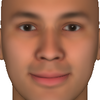

In [21]:
# taking a sample observation
img1, emo1, out1 = face_outcome_emotion_dataset[5]
print("Sample Observation: ")
print(helperCode.EMOTION_VAR_NAMES)
print(emo1)
print(helperCode.OUTCOME_VAR_NAMES)
print(out1)
Image.fromarray(helperCode.TensorToPILImage(img1))

In [53]:
class testModule(nn.Module):
    """
    define the PyTorch module that parametrizes q(z|image).
    This goes from images to the latent z
    
    This is the standard DCGAN architecture.
    """
    def __init__(self, z_dim):
        super(testModule, self).__init__()
        self.features = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
                Swish(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                Swish(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                Swish(),
                nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(256),
                Swish())
        self.classifier = nn.Sequential(
            #nn.Linear(256 * 5 * 5, 512), # it's 256 * 5 * 5 if input is 64x64.
            nn.Linear(256 * 9 * 9, 512), # it's 256 * 9 * 9 if input is 100x100.
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, z_dim * 2))
        self.z_dim = z_dim

    def forward(self, image):
        image = self.features(image)
        # image = image.view(-1, 256 * 5 * 5) # it's 256 * 5 * 5 if input is 64x64.
        image = image.view(-1, 256 * 9 * 9) # it's 256 * 9 * 9 if input is 100x100.
        image = self.classifier(image)
        return image[:, :self.z_dim], image[:, self.z_dim:]

class testModuleDecoder(nn.Module):
    """
    define the PyTorch module that parametrizes p(image|z).
    This goes from the latent z to the images
    
    This is the standard DCGAN architecture.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(testModuleDecoder, self).__init__()
        self.upsample = nn.Sequential(
            nn.Linear(z_dim, 256 * 9 * 9),
            Swish())
        self.hallucinate = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            Swish(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            Swish(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            Swish(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False))

    def forward(self, z):
        # the input will be a vector of size |z_dim|
        z = self.upsample(z)
        z = z.view(-1, 256, 9, 9)
        image = self.hallucinate(z) # this is the image
        return image  # NOTE: no sigmoid here. See train.py

#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
#                padding=0, dilation=1, groups=1, bias=True)
# self.classifier = nn.Sequential(
#     nn.Linear(256 * 5 * 5, 512),
#     Swish(),
#     nn.Dropout(p=0.1),
#     nn.Linear(512, z_dim * 2))
# self.z_dim = z_dim

testN = testModule(100)
testN2 = testModuleDecoder(100)
#testN.net

imgBatch = torch.unsqueeze(img1, 0)
print(imgBatch.shape)
testN.forward(imgBatch)
testN2.forward(imgBatch).shape

#mvae.image_encoder(imgBatch)

#     def forward(self, image):

#         image = image.view(-1, 256 * 5 * 5)
#         image = self.classifier(image)
#         return image[:, :self.z_dim], image[:, self.z_dim:]

torch.Size([1, 3, 100, 100])


torch.Size([300, 3, 96, 96])

In [31]:
mvae.image_encoder

ImageEncoder(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Swish()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Swish()
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Swish()
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Swish()
  )
  (classifier): Sequential(
    (0): Linear(in_features=6400, out_features=512, bias=True)
    (1): Swish()
    (2): Dropout(p=0.1)
    (3): Linear(in_features=512, out_features=20, bias=True)
  )
)

-----

Written by: Desmond Ong (desmond.c.ong@gmail.com), Harold Soh (hsoh@comp.nus.edu.sg), Mike Wu (wumike@stanford.edu)

References:

Pyro [VAE tutorial](http://pyro.ai/examples/vae.html)

Wu, M., & Goodman, N. D. (2018). Multimodal Generative Models for Scalable Weakly-Supervised Learning. To appear, NIPS 2018, https://arxiv.org/abs/1802.05335
Repo here: https://github.com/mhw32/multimodal-vae-public

DCGAN https://arxiv.org/pdf/1511.06434.pdf

Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. (2013). Stochastic variational inference. *The Journal of Machine Learning Research*, 14(1), 1303-1347.

Kingma, D. P., Mohamed, S., Rezende, D. J., & Welling, M. (2014). Semi-supervised learning with deep generative models. In *Advances in Neural Information Processing Systems*, pp. 3581-3589. https://arxiv.org/abs/1406.5298

Kingma, D. P., & Welling, M. (2014). Auto-encoding variational bayes. Auto-Encoding Variational Bayes. In *The International Conference on Learning Representations*. https://arxiv.org/abs/1312.6114


Narayanaswamy, S., Paige, T. B., van de Meent, J. W., Desmaison, A., Goodman, N. D., Kohli, P., Wood, F. & Torr, P. (2017). Learning Disentangled Representations with Semi-Supervised Deep Generative Models. In *Advances in Neural Information Processing Systems*, pp. 5927-5937. https://arxiv.org/abs/1706.00400

Data from https://github.com/desmond-ong/affCog, from the following paper:

Ong, D. C., Zaki, J., & Goodman, N. D. (2015). Affective Cognition: Exploring lay theories of emotion. *Cognition*, 143, 141-162.